In [1]:
from operator import itemgetter
import os
import re
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import namedtuple
import csv
from itertools import repeat
import numpy as np
import math
import scipy.interpolate as inter
from statistics import mean

In [3]:
def read_verification_log(file_name):
    '''
    Read generated verification data from a csv file.

    Return: tuple of recorded errors and accuracies
    '''
    Errors = []
    Accs = []
    VerificationRecord = namedtuple('VerificationRecord', 'opt_error, accuracy')
    
    with open(file_name) as csvfile:
        readCSV = map(VerificationRecord._make, csv.reader(csvfile, delimiter=','))
        for row in readCSV:
            Errors.append(float(row.opt_error))
            Accs.append(float(row.accuracy))
    return (Errors, Accs)

    
# Smoothing as in TB: https://github.com/tensorflow/tensorflow/blob/905662a1c047f314ad295e27d2e2a00b4aa51e90/tensorflow/tensorboard/components/vz_line_chart/vz-line-chart.ts#L432
# Assume that we only have finite numbers.
def smooth_data(data, smoothing_weight=0.6):
    factor = ((1000** smoothing_weight) - 1) / 999
    kernel_radius = math.floor(len(data) * factor / 2)
    
    Y_smoothed = []
    
    for i, d in enumerate(data):
        actual_kernel_radius = min(kernel_radius, i, len(data) - i - 1)
        start = i - actual_kernel_radius
        end = i + actual_kernel_radius + 1
        
        Y_smoothed.append(mean(data[start:end]))
    
    return Y_smoothed


def plot_progress(X, Y, title='', ymax=1, ymin=0, ylabel=''):
    plt.ylim(ymin, ymax)
    plt.plot(X, Y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    #plt.legend(['test'], loc='upper right')
    plt.show()

    
def interpolate_spline(X,Y, spacing, smoothing=0.0):
    s1 = inter.UnivariateSpline(X, Y, s=smoothing)
    xNew = np.linspace(min(X),max(X),spacing)
    return xNew, s1(xNew)


def monotone_progress(Accs):
    maximum = 0
    monotoneValues = []
    for acc in Accs:
        maximum = maximum if acc < maximum else acc
        monotoneValues.append(maximum)
    return monotoneValues
        

In [4]:
def plot_progress_3(x1, y1, title1,
                    x2, y2, title2,
                    x3, y3, title3,
                    ymax=1, ymin=0, ylabel=''):

    min_len = min(len(x1), len(x2), len(x3))
    # x1 = x1[:min_len]
    # x2 = x2[:min_len]
    # x3 = x3[:min_len]
    # y1 = y1[:min_len]
    # y2 = y2[:min_len]
    # y3 = y3[:min_len]

    fig, axs = plt.subplots(1,3,figsize=(15,5))
    xlabel = 'Communication round'

    axs[0].set_title(title1)
    axs[0].set_ylabel(ylabel)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylim(ymin, ymax)

    axs[0].plot(x1, y1, 'c')

    axs[1].set_title(title2)
    axs[1].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylim(ymin, ymax)

    axs[1].plot(x2, y2, 'm')
    
    axs[2].set_title(title3)
    axs[2].set_ylabel(ylabel)
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylim(ymin, ymax)

    axs[2].plot(x3, y3, 'y')


def plot_on_plots(x1, y1,
                  x2, y2,
                  x3, y3, title,
                  ymax=1, ymin=0, ylabel=''):

    min_len = min(len(x1), len(x2), len(x3))
    x1 = x1[:min_len]
    x2 = x2[:min_len]
    x3 = x3[:min_len]
    y1 = y1[:min_len]
    y2 = y2[:min_len]
    y3 = y3[:min_len]

    plt.ylim(ymin, ymax)
    var1, = plt.plot(x2, y2, 'k', label='variant 1')
    var0, = plt.plot(x1, y1, 'r', label='variant 0')
    var2, = plt.plot(x3, y3, 'y', label='variant 2')
    var0Monotone = plt.plot(x2, monotone_progress(y2), color='lightgray', alpha=0.5)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    plt.legend(handles=[var0, var1, var2])

    pdf_path = "../benchmark_results/plot_" + title.replace(' ', '_') + ".pdf"
    plt.savefig(pdf_path, format='pdf')    
    plt.show()

In [5]:
def simple_plot_progress(Y, title='', ymax=1, ymin=0, ylabel=''):
    plt.ylim(ymin, ymax)
    plt.plot(Y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    plt.show()
    
def plot_overlap(*yls, ymin=0.0, ymax=1.0, file_name=None, title=None):

    fig = plt.figure(figsize=(5,4), dpi=100)
    #min_len = min([len(y) for y in ys])
    for y in yls[0]:
        #y = y[:min_len]
        y_maxes = y #monotone_progress(y)
        plt.plot(y_maxes, alpha=0.5)
    
    if ymax == None:
        ymax = max([max(y) for y in yls[0]])
    
    plt.ylim(ymin, ymax)

    plt.ylabel("Accuracy")
    plt.xlabel("Communication rounds")
    plt.legend(yls[1], loc='lower right')
    
    if title:
        plt.title(title)
    
    if file_name:
        plt.savefig(file_name, format='pdf')
    
    plt.show(fig)

In [6]:
def extract_C_E(string):
    c_match = re.search(r'(?<=_C)\d+.\d+', string)
    c = c_match.group(0)
    e_match = re.search(r'(?<=_E)\d+', string)
    e = e_match.group(0)
    return (c,e) # 'C={},E={}'.format

def plot_score_logs_e(score_logs, title=None, file_name=None):
    accs = [read_verification_log(file)[1][:1000] for file in score_logs]
    max_acc = [max(a) for a in accs]
    cs_es = ['$C={}$, max: ${:.3}\%$'.format(extract_C_E(file)[0], ma*100) for file, ma in zip(score_logs, max_acc)]
    accs_labels = (accs, cs_es)

    plot_overlap(*accs_labels, ymin=0.9, ymax=0.98, file_name=file_name, title=title)

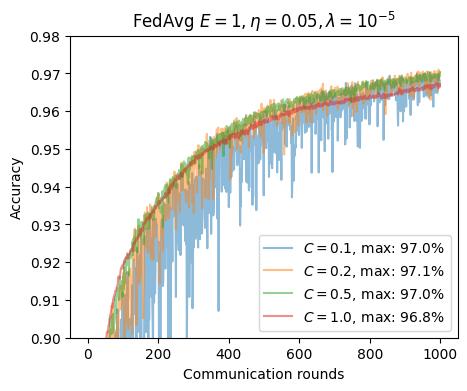

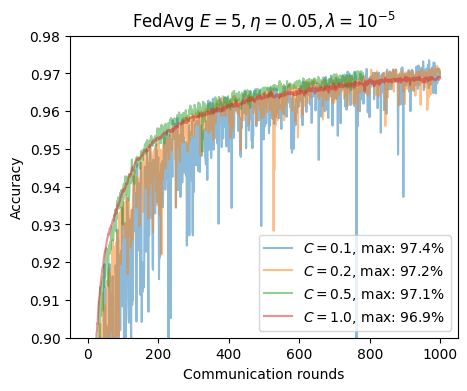

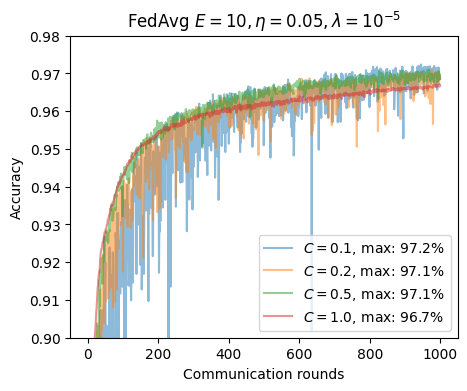

In [7]:
from pathlib import Path

RESULT_DIR = Path('../benchmark_results/fedavg')
NONIID_DIR = RESULT_DIR / 'non-iid'

score_logs = glob.glob(str(NONIID_DIR / '*.csv'))
def sort_key(x):
    c,e =extract_C_E(x)
    c = float(c)
    e = int(e)
    return c+e
sorted_logs = sorted(score_logs, key=sort_key)

plot_score_logs_e(sorted_logs[:4], 'FedAvg $E=1, \eta=0.05, \lambda=10^{-5}$', NONIID_DIR / 'plot_stable_E1.pdf')
plot_score_logs_e(sorted_logs[4:8], 'FedAvg $E=5, \eta=0.05, \lambda=10^{-5}$', NONIID_DIR / 'plot_stable_E5.pdf')
plot_score_logs_e(sorted_logs[8:], 'FedAvg $E=10, \eta=0.05, \lambda=10^{-5}$', NONIID_DIR / 'plot_stable_E10.pdf')

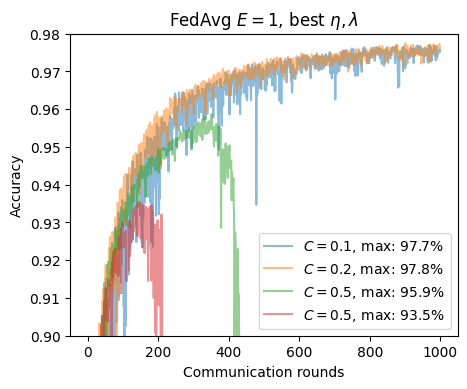

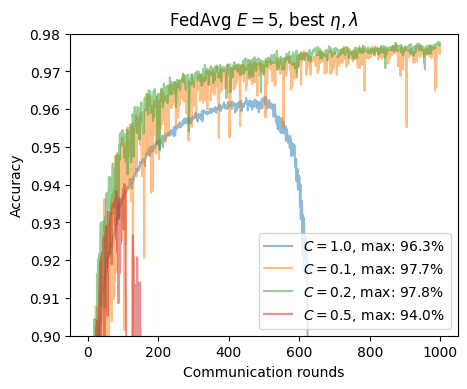

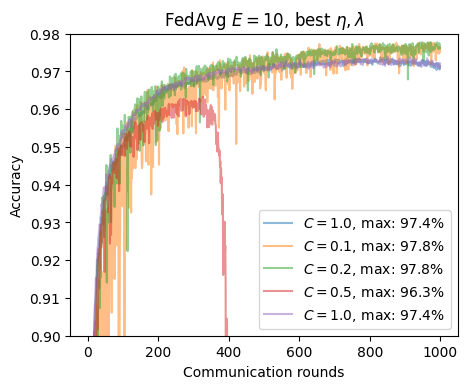

In [8]:
BEC_DIR = RESULT_DIR / 'B-E-C'
score_logs = glob.glob(str(BEC_DIR / '*.csv'))

def sort_key(x):
    c,e =extract_C_E(x)
    c = float(c)
    e = int(e)
    return c+e
sorted_logs = sorted(score_logs, key=sort_key)

pdf_path = BEC_DIR / 'plot_E1.pdf'
title = 'FedAvg $E=1$, best $\eta, \lambda$'
plot_score_logs_e(sorted_logs[:4], title, pdf_path)

pdf_path = BEC_DIR / 'plot_E5.pdf'
title = 'FedAvg $E=5$, best $\eta, \lambda$'
plot_score_logs_e(sorted_logs[4:8], title, pdf_path)

pdf_path = BEC_DIR / 'plot_E10.pdf'
title = 'FedAvg $E=10$, best $\eta, \lambda$'
plot_score_logs_e(sorted_logs[8:], title, pdf_path)

In [9]:
c0 = RESULT_DIR / 'verification_log_MNIST_nonIID_2NN_C1_E1_B10_LR0.11_Decay_2.2e-7.csv'
acc0 = read_verification_log(c0)[1]
max(acc0[:])

0.9857